In [ ]:
!pip install fasttext --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
df = pd.read_csv('mlft_preprocessedv2.csv')
df.head()

,content,score,casefold,remove noise,slang,stopwords,stopwords2,stem,sentiment
0,sangat membantu terimakasih stockbit,5,sangat membantu terimakasih stockbit,sangat membantu terimakasih stockbit,sangat membantu terima kasih stockbit,membantu terima kasih stockbit,membantu terima kasih stockbit,bantu terima kasih stockbit,pos
1,"Aplikasi sudah bagis, fitur san tampilan enak,...",5,"aplikasi sudah bagis, fitur san tampilan enak,...",aplikasi sudah bagis fitur san tampilan enak m...,aplikasi sudah bagis fitur san tampilan enak m...,aplikasi bagis fitur san tampilan enak mudah p...,aplikasi bagis fitur san tampilan enak mudah p...,aplikasi bagis fitur san tampil enak mudah pah...,pos
2,Semoga aplikasi ini berguna bagi konsumen 😍😍😍,5,semoga aplikasi ini berguna bagi konsumen 😍😍😍,semoga aplikasi ini berguna bagi konsumen,semoga aplikasi ini berguna bagi konsumen,semoga aplikasi berguna konsumen,semoga aplikasi berguna konsumen,moga aplikasi guna konsumen,pos
3,Aplikasi yg bagus untuk belajar jad investor m...,5,aplikasi yg bagus untuk belajar jad investor m...,aplikasi yg bagus untuk belajar jad investor m...,aplikasi yang bagus untuk belajar jadi investo...,aplikasi bagus belajar investor trader,aplikasi bagus belajar investor trader,aplikasi bagus ajar investor trader,pos
4,Bagus untuk pemula yang mau terjuan ke dunia p...,5,bagus untuk pemula yang mau terjuan ke dunia p...,bagus untuk pemula yang mau terjuan ke dunia p...,bagus untuk pemula yang mau terjuan ke dunia p...,bagus pemula terjuan dunia persahaman crypto a...,bagus pemula terjuan dunia persahaman crypto a...,bagus mula juan dunia saham crypto admin stock...,pos


In [ ]:
X = df['stopwords'].astype(str)
y = df['sentiment'].astype(str)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
!gunzip -k cc.id.300.bin.gz

--2025-12-15 16:14:47--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.74.45, 13.227.74.9, 13.227.74.12, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.74.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4507049071 (4.2G) [application/octet-stream]
Saving to: ‘cc.id.300.bin.gz’

cc.id.300.bin.gz    100%[===================>]   4.20G  76.3MB/s    in 57s     

2025-12-15 16:15:45 (75.1 MB/s) - ‘cc.id.300.bin.gz’ saved [4507049071/4507049071]



In [ ]:
import fasttext

ft_model = fasttext.load_model('/content/drive/MyDrive/kuliah/MLFT/cc.id.300.bin')

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

In [ ]:
import numpy as np

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = ft_model.get_dimension()

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in ft_model:
        embedding_matrix[i] = ft_model.get_word_vector(word)

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (5395, 300)


In [ ]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [ ]:
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_sequence_length,
        trainable=False
    ),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.3),
    BatchNormalization(),

    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     1,618,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,618,500 (6.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,618,500 (6.17 MB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

history = model.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_test_pad, y_test_enc),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

Class Weights: {0: np.float64(1.0001965408805031), 1: np.float64(0.999803536345776)}
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7324 - loss: 0.5587 - val_accuracy: 0.5782 - val_loss: 0.6393 - learning_rate: 5.0000e-04
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8284 - loss: 0.4045 - val_accuracy: 0.5310 - val_loss: 0.6509 - learning_rate: 5.0000e-04
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8511 - loss: 0.3563 - val_accuracy: 0.7015 - val_loss: 0.5304 - learning_rate: 5.0000e-04
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8563 - loss: 0.3443 - val_accuracy: 0.7581 - val_loss: 0.4674 - learning_rate: 5.0000e-04
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8631 - loss: 0.3523 - val_accuracy: 0.8036 - val_loss: 0.4172 - learning_rate: 5.0000e-04
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8807 - loss: 0.3043 - val_accuracy: 0.8421 - val_loss: 0.3673 - learning_ra

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


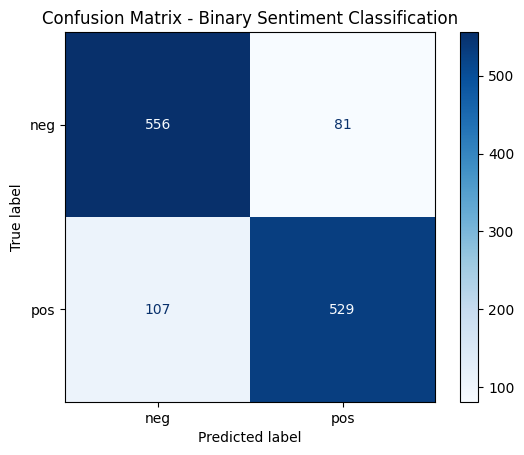


Classification Report:
              precision    recall  f1-score   support

         neg       0.84      0.87      0.86       637
         pos       0.87      0.83      0.85       636

    accuracy                           0.85      1273
   macro avg       0.85      0.85      0.85      1273
weighted avg       0.85      0.85      0.85      1273



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Binary Sentiment Classification")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))

In [ ]:
import fasttext
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Load the sentiment model
sentiment_model = load_model('sentiment_model.h5')


factory_stopword = StopWordRemoverFactory()
stopword_remover = factory_stopword.create_stop_word_remover()

df_sentiment = pd.read_csv('mlft_preprocessedv2.csv')
X_sentiment_train, _, _, _ = train_test_split(df_sentiment['stopwords'].astype(str), df_sentiment['sentiment'].astype(str), test_size=0.2, random_state=42)

sentiment_tokenizer = Tokenizer(oov_token="<OOV>")
sentiment_tokenizer.fit_on_texts(X_sentiment_train)

# Recreate label_encoder for sentiment model
sentiment_label_encoder = LabelEncoder()
sentiment_label_encoder.fit(df_sentiment['sentiment'].astype(str))

max_sequence_length = 100 

def preprocess_text_for_sentiment(text):
    text = text.lower()  # Casefolding
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove noise (non-alphabetic characters)

    text = stopword_remover.remove(text)  # Remove stopwords
    text = stemmer.stem(text)  # Stemming
    return text

def predict_sentiment(text):
    processed_text = preprocess_text_for_sentiment(text)
    sequence = sentiment_tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post', truncating='post')

    prediction = sentiment_model.predict(padded_sequence)

    predicted_class_index = (prediction > 0.5).astype(int)[0][0]
    predicted_label = sentiment_label_encoder.inverse_transform([predicted_class_index])[0]

    return predicted_label, prediction[0][0]

print("Sentiment model and prediction function loaded.")

Sentiment model and prediction function loaded.


In [ ]:
# Test with a positive review
sample_text_pos = "tampilan nya bagus"
predicted_sentiment_pos, prob_pos = predict_sentiment(sample_text_pos)
print(f"Text: '{sample_text_pos}'")
print(f"Predicted Sentiment: {predicted_sentiment_pos} (Probability: {prob_pos:.4f})\n")

# Test with a negative review
sample_text_neg = "Aplikasinya sering error dan lambat, sangat mengecewakan."
predicted_sentiment_neg, prob_neg = predict_sentiment(sample_text_neg)
print(f"Text: '{sample_text_neg}'")
print(f"Predicted Sentiment: {predicted_sentiment_neg} (Probability: {prob_neg:.4f})\n")

# Test with a neutral-ish review (might lean one way or another depending on training)
sample_text_neutral = "Fiturnya lumayan lengkap tapi tampilannya kurang menarik."
predicted_sentiment_neutral, prob_neutral = predict_sentiment(sample_text_neutral)
print(f"Text: '{sample_text_neutral}'")
print(f"Predicted Sentiment: {predicted_sentiment_neutral} (Probability: {prob_neutral:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Text: 'tampilan nya bagus'
Predicted Sentiment: pos (Probability: 0.8025)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Text: 'Aplikasinya sering error dan lambat, sangat mengecewakan.'
Predicted Sentiment: neg (Probability: 0.0221)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Text: 'Fiturnya lumayan lengkap tapi tampilannya kurang menarik.'
Predicted Sentiment: pos (Probability: 0.9235)



### Save the Sentiment Classification Model

In [ ]:
model.save('sentiment_model.h5')
print("Sentiment classification model saved as sentiment_model.h5")

Sentiment classification model saved as sentiment_model.h5


#Test Classification Model Topic

In [ ]:
import pandas as pd
df = pd.read_csv('/content/mlft_preprocessed_topic.csv')
df.head()

,content,score,casefold,remove noise,slang,stopwords,stopwords2,stem,sentiment,topic
0,sangat membantu terimakasih stockbit,5,sangat membantu terimakasih stockbit,sangat membantu terimakasih stockbit,sangat membantu terima kasih stockbit,membantu terima kasih stockbit,membantu terima kasih stockbit,bantu terima kasih stockbit,pos,2
1,"Aplikasi sudah bagis, fitur san tampilan enak,...",5,"aplikasi sudah bagis, fitur san tampilan enak,...",aplikasi sudah bagis fitur san tampilan enak m...,aplikasi sudah bagis fitur san tampilan enak m...,aplikasi bagis fitur san tampilan enak mudah p...,aplikasi bagis fitur san tampilan enak mudah p...,aplikasi bagis fitur san tampil enak mudah pah...,pos,0
2,Semoga aplikasi ini berguna bagi konsumen 😍😍😍,5,semoga aplikasi ini berguna bagi konsumen 😍😍😍,semoga aplikasi ini berguna bagi konsumen,semoga aplikasi ini berguna bagi konsumen,semoga aplikasi berguna konsumen,semoga aplikasi berguna konsumen,moga aplikasi guna konsumen,pos,0
3,Aplikasi yg bagus untuk belajar jad investor m...,5,aplikasi yg bagus untuk belajar jad investor m...,aplikasi yg bagus untuk belajar jad investor m...,aplikasi yang bagus untuk belajar jadi investo...,aplikasi bagus belajar investor trader,aplikasi bagus belajar investor trader,aplikasi bagus ajar investor trader,pos,3
4,Bagus untuk pemula yang mau terjuan ke dunia p...,5,bagus untuk pemula yang mau terjuan ke dunia p...,bagus untuk pemula yang mau terjuan ke dunia p...,bagus untuk pemula yang mau terjuan ke dunia p...,bagus pemula terjuan dunia persahaman crypto a...,bagus pemula terjuan dunia persahaman crypto a...,bagus mula juan dunia saham crypto admin stock...,pos,2


In [ ]:
df.value_counts('topic')

,count
topic,
0,1417
1,1092
3,897
2,867
4,773
7,503
6,499
5,312
-1,2


In [ ]:
df = df[df['topic'] != -1]
df.value_counts('topic')

,count
topic,
0,1417
1,1092
3,897
2,867
4,773
7,503
6,499
5,312


In [ ]:
from sklearn.preprocessing import LabelEncoder
merged_label_encoder = LabelEncoder()
df['merged_topic_encoded'] = merged_label_encoder.fit_transform(df['topic'])

print("Original topic distribution:")
print(df['topic'].value_counts())
print("\nMerged topic distribution:")
print(df['merged_topic_name'].value_counts())
print("\nMerged topic names and their encoded values:")
for i, name in enumerate(merged_label_encoder.classes_):
    print(f"{name}: {i}")

X_merged = df['stopwords'].astype(str)
y_merged = df['merged_topic_encoded'].astype(int)

Original topic distribution:
topic
0    1417
1    1092
3     897
2     867
4     773
7     503
6     499
5     312
Name: count, dtype: int64

Merged topic distribution:
merged_topic_name
fitur dan kemudahan investasi    2856
akses aplikasi                   1417
stabilitas sistem perdagangan    1276
proses transaksi keuangan         499
integrasi rekening bank           312
Name: count, dtype: int64

Merged topic names and their encoded values:
akses aplikasi: 0
fitur dan kemudahan investasi: 1
integrasi rekening bank: 2
proses transaksi keuangan: 3
stabilitas sistem perdagangan: 4


In [ ]:
from sklearn.model_selection import train_test_split

X_train_merged, X_test_merged, y_train_merged, y_test_merged = train_test_split(X_merged, y_merged, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

tokenizer_merged = Tokenizer(oov_token="<OOV>")
tokenizer_merged.fit_on_texts(X_train_merged)

X_train_seq_merged = tokenizer_merged.texts_to_sequences(X_train_merged)
X_test_seq_merged = tokenizer_merged.texts_to_sequences(X_test_merged)

max_sequence_length = 100 # Re-using the same max_sequence_length
X_train_pad_merged = pad_sequences(X_train_seq_merged, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_pad_merged = pad_sequences(X_test_seq_merged, maxlen=max_sequence_length, padding='post', truncating='post')

vocab_size_merged = len(tokenizer_merged.word_index) + 1
embedding_dim = ft_model.get_dimension()

embedding_matrix_merged = np.zeros((vocab_size_merged, embedding_dim))
for word, i in tokenizer_merged.word_index.items():
    if word in ft_model:
        embedding_matrix_merged[i] = ft_model.get_word_vector(word)

print("Embedding matrix shape for merged topics:", embedding_matrix_merged.shape)

Embedding matrix shape for merged topics: (4174, 300)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

num_merged_classes = len(merged_label_encoder.classes_)

model_merged = Sequential([
    Embedding(
        input_dim=vocab_size_merged,
        output_dim=embedding_dim,
        weights=[embedding_matrix_merged],
        input_length=max_sequence_length,
        trainable=False
    ),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.3),
    BatchNormalization(),

    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_merged_classes, activation='softmax')
])

optimizer_merged = Adam(learning_rate=1e-3)
model_merged.compile(optimizer=optimizer_merged, loss='categorical_crossentropy', metrics=['accuracy'])
model_merged.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     1,252,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,252,200 (4.78 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,252,200 (4.78 MB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop_merged = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr_merged = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

class_weights_merged = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_merged),
    y=y_train_merged
)
class_weights_merged = dict(enumerate(class_weights_merged))
print("Class Weights for merged topics:", class_weights_merged)

y_train_one_hot_merged = to_categorical(y_train_merged, num_classes=num_merged_classes)
y_test_one_hot_merged = to_categorical(y_test_merged, num_classes=num_merged_classes)

history_merged = model_merged.fit(
    X_train_pad_merged, y_train_one_hot_merged,
    validation_data=(X_test_pad_merged, y_test_one_hot_merged),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop_merged, reduce_lr_merged],
    class_weight=class_weights_merged,
    verbose=1
)

Class Weights for merged topics: {0: np.float64(0.8981465136804943), 1: np.float64(0.44166666666666665), 2: np.float64(3.9595330739299612), 3: np.float64(2.609230769230769), 4: np.float64(1.0135458167330678)}
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.3907 - loss: 1.6032 - val_accuracy: 0.4882 - val_loss: 1.4269 - learning_rate: 0.0010
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5921 - loss: 0.9443 - val_accuracy: 0.5527 - val_loss: 1.3082 - learning_rate: 0.0010
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6872 - loss: 0.7255 - val_accuracy: 0.6234 - val_loss: 1.0725 - learning_rate: 0.0010
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7066 - loss: 0.6469 - val_accuracy: 0.6612 - val_loss: 0.9098 - learning_rate: 0.0010
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7475 - loss: 0.5560 - val_accuracy: 0.6659 - val_loss: 0.9235 - learning_rate: 0.0010
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


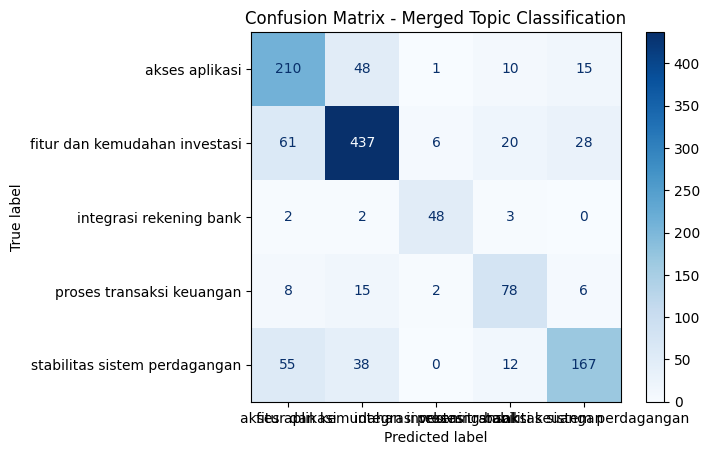


Classification Report for merged topics:
                               precision    recall  f1-score   support

               akses aplikasi       0.62      0.74      0.68       284
fitur dan kemudahan investasi       0.81      0.79      0.80       552
      integrasi rekening bank       0.84      0.87      0.86        55
    proses transaksi keuangan       0.63      0.72      0.67       109
stabilitas sistem perdagangan       0.77      0.61      0.68       272

                     accuracy                           0.74      1272
                    macro avg       0.74      0.75      0.74      1272
                 weighted avg       0.75      0.74      0.74      1272



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs_merged = model_merged.predict(X_test_pad_merged)
y_pred_merged = np.argmax(y_pred_probs_merged, axis=1)

cm_merged = confusion_matrix(y_test_merged, y_pred_merged)
disp_merged = ConfusionMatrixDisplay(confusion_matrix=cm_merged, display_labels=merged_label_encoder.classes_)
disp_merged.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Merged Topic Classification")
plt.show()

print("\nClassification Report for merged topics:")
print(classification_report(y_test_merged, y_pred_merged, target_names=merged_label_encoder.classes_))

### Save the Merged Topic Classification Model

In [ ]:
model_merged.save('merged_topic_model.h5')
print("Merged topic classification model saved as merged_topic_model.h5")

Merged topic classification model saved as merged_topic_model.h5
